<a href="https://colab.research.google.com/github/Tatiana-Polonskaya/easy_awakening/blob/main/model_detect_sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from datetime import datetime, timedelta,time

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score,roc_curve,roc_auc_score

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Этапы работы:**
1. Произвести сбор датасета;
2. Определить предикторы;
3. Провести анализ и выбрать оптимальный алгоритм для реализации задачи выбранной темы (на основе сравнительного анализа);
4. Обосновать выбор алгоритма (сравнительный анализ необходимо представить в табличном виде);
5. Реализовать алгоритм на языке программирования Python; 
6. Сделать вывод по проделанной работе (выдать численные значения и сравнительную таблицу по аналогичным решениям по accuracy/f1 score, описать полученные значения и возможные ограничения полученного решения и будущего улучшения).


# Получение датасета

Получаем данные о пульсе в течение дня

In [ ]:
pulses = pd.read_csv('/content/drive/MyDrive/Sleep_MO/14.03/HEARTRATE_AUTO/HEARTRATE_AUTO_1678790378309.csv')
pulses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13336 entries, 0 to 13335
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       13336 non-null  object
 1   time       13336 non-null  object
 2   heartRate  13336 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.7+ KB


In [ ]:
pulses.head()

,date,time,heartRate
0,2023-03-01,15:21,90
1,2023-03-01,15:22,79
2,2023-03-01,15:23,84
3,2023-03-01,15:24,81
4,2023-03-01,15:25,92


Отбираем только те дни, у которых есть сведения о SpO2

In [ ]:
df_pulses = pulses[(pulses.date.isin(['2023-03-13','2023-03-12','2023-03-11','2023-03-10','2023-03-14']))]
df_pulses

,date,time,heartRate
10479,2023-03-10,00:00,69
10480,2023-03-10,00:01,67
10481,2023-03-10,00:02,69
10482,2023-03-10,00:03,71
10483,2023-03-10,00:04,71
...,...,...,...
13331,2023-03-14,11:51,88
13332,2023-03-14,12:01,84
13333,2023-03-14,12:11,77
13334,2023-03-14,12:21,76


Преобразовываем дату и время

In [ ]:
df_pulses['time'] = df_pulses.time.dt.time
df_pulses['date_time'] = df_pulses[['date','time']].apply(lambda x: str(x[0]) + ' ' + str(x[1]),axis=1) 
df_pulses.date_time = pd.to_datetime(df_pulses.date_time)
df_pulses.date = pd.to_datetime(df_pulses.date)
df_pulses

<ipython-input-45-cc914bf21d38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pulses['date_time'] = df_pulses[['date','time']].apply(lambda x: str(x[0]) + ' ' + str(x[1]),axis=1)


,date,time,heartRate,date_time
10479,2023-03-10,00:00:00,69,2023-03-10 00:00:00
10480,2023-03-10,00:01:00,67,2023-03-10 00:01:00
10481,2023-03-10,00:02:00,69,2023-03-10 00:02:00
10482,2023-03-10,00:03:00,71,2023-03-10 00:03:00
10483,2023-03-10,00:04:00,71,2023-03-10 00:04:00
...,...,...,...,...
13331,2023-03-14,11:51:00,88,2023-03-14 11:51:00
13332,2023-03-14,12:01:00,84,2023-03-14 12:01:00
13333,2023-03-14,12:11:00,77,2023-03-14 12:11:00
13334,2023-03-14,12:21:00,76,2023-03-14 12:21:00


In [ ]:
df_pulses.date_time = pd.to_datetime(df_pulses.date_time, unit='s', utc=True)

In [ ]:
df_pulses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2857 entries, 10479 to 13335
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       2857 non-null   datetime64[ns]     
 1   time       2857 non-null   object             
 2   heartRate  2857 non-null   int64              
 3   date_time  2857 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(1), object(1)
memory usage: 111.6+ KB


Извлекаем данные о сне и добавляем целевую переменную

In [ ]:
sleeps = pd.read_csv('/content/drive/MyDrive/Sleep_MO/14.03/SLEEP/SLEEP_1678790378210.csv')
sleeps

,date,deepSleepTime,shallowSleepTime,wakeTime,start,stop,REMTime,naps
0,2023-03-01,141,464,3,2023-02-28 19:36:00+0000,2023-03-01 05:44:00+0000,0,NaN
1,2023-03-02,0,0,0,2023-03-02 21:00:00+0000,2023-03-02 21:00:00+0000,0,NaN
2,2023-03-03,81,407,9,2023-03-02 19:59:00+0000,2023-03-03 05:47:00+0000,91,NaN
3,2023-03-04,71,225,3,2023-03-03 19:59:00+0000,2023-03-04 02:48:00+0000,110,NaN
4,2023-03-05,65,436,0,2023-03-04 19:22:00+0000,2023-03-05 05:15:00+0000,92,NaN
5,2023-03-06,41,309,0,2023-03-05 23:56:00+0000,2023-03-06 06:33:00+0000,47,NaN
6,2023-03-07,103,188,10,2023-03-06 22:46:00+0000,2023-03-07 05:48:00+0000,121,NaN
7,2023-03-08,73,335,0,2023-03-07 22:15:00+0000,2023-03-08 05:54:00+0000,51,NaN
8,2023-03-09,0,0,0,2023-03-09 21:00:00+0000,2023-03-09 21:00:00+0000,0,NaN
9,2023-03-10,92,229,37,2023-03-09 21:07:00+0000,2023-03-10 05:14:00+0000,129,NaN


Отбираем только тот сон, у которого есть SpO2 

In [ ]:
df_sleeps = sleeps[(sleeps.date.isin(['2023-03-13','2023-03-12','2023-03-11','2023-03-10','2023-03-14']))]
df_sleeps

,date,deepSleepTime,shallowSleepTime,wakeTime,start,stop,REMTime,naps
9,2023-03-10,92,229,37,2023-03-09 21:07:00+0000,2023-03-10 05:14:00+0000,129,NaN
10,2023-03-11,53,282,0,2023-03-10 22:29:00+0000,2023-03-11 05:03:00+0000,59,NaN
11,2023-03-12,71,412,0,2023-03-11 20:26:00+0000,2023-03-12 05:05:00+0000,36,NaN
12,2023-03-13,100,285,0,2023-03-12 21:24:00+0000,2023-03-13 05:05:00+0000,76,NaN
13,2023-03-14,36,130,0,2023-03-14 01:48:00+0000,2023-03-14 05:23:00+0000,49,NaN


In [ ]:
df_sleeps.start = pd.to_datetime(df_sleeps.start) + pd.Timedelta('03:00:00')
df_sleeps.stop = pd.to_datetime(df_sleeps.stop) + pd.Timedelta('03:00:00')
df_sleeps.start = pd.to_datetime(df_sleeps.start, unit='s', utc=True) 
df_sleeps.stop = pd.to_datetime(df_sleeps.stop, unit='s', utc=True)

df_sleeps.date = pd.to_datetime(df_sleeps.date)

In [ ]:
df_sleeps

,date,deepSleepTime,shallowSleepTime,wakeTime,start,stop,REMTime,naps
9,2023-03-10,92,229,37,2023-03-10 00:07:00+00:00,2023-03-10 08:14:00+00:00,129,NaN
10,2023-03-11,53,282,0,2023-03-11 01:29:00+00:00,2023-03-11 08:03:00+00:00,59,NaN
11,2023-03-12,71,412,0,2023-03-11 23:26:00+00:00,2023-03-12 08:05:00+00:00,36,NaN
12,2023-03-13,100,285,0,2023-03-13 00:24:00+00:00,2023-03-13 08:05:00+00:00,76,NaN
13,2023-03-14,36,130,0,2023-03-14 04:48:00+00:00,2023-03-14 08:23:00+00:00,49,NaN


Добавляем в данные переменную кислород в крови из другого датасета

In [ ]:
spo2_data = pd.read_csv('/content/drive/MyDrive/Sleep_MO/14.03/data_spo2.csv')
spo2_data.rename(columns=({"Проценты":"spo","Время":"time","Дата":"date"}),inplace=True)
spo2_data

,spo,time,date
0,99%,0:05,13.03.2023
1,99%,0:10,13.03.2023
2,95%,0:15,13.03.2023
3,99%,0:25,13.03.2023
4,98%,0:30,13.03.2023
...,...,...,...
419,99%,23:35,11.03.2023
420,99%,23:40,11.03.2023
421,99%,23:45,11.03.2023
422,97%,23:50,11.03.2023


In [ ]:
spo2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spo     424 non-null    object
 1   time    424 non-null    object
 2   date    424 non-null    object
dtypes: object(3)
memory usage: 10.1+ KB


In [ ]:
spo2_data.drop_duplicates(inplace=True)
spo2_data.shape

(403, 3)

Подготовим признак дата и время для объединения с другими датасетами

In [ ]:
spo2_data.date = pd.to_datetime(spo2_data.date,infer_datetime_format=True)
spo2_data['date_time'] = spo2_data[['date','time']].apply(lambda x: str(x[0]) + ' ' + str(x[1]),axis=1) 
spo2_data.date_time = pd.to_datetime(spo2_data.date_time)

In [ ]:
spo2_data.date_time

0     2023-03-13 00:05:00
1     2023-03-13 00:10:00
2     2023-03-13 00:15:00
3     2023-03-13 00:25:00
4     2023-03-13 00:30:00
              ...        
419   2023-03-11 23:35:00
420   2023-03-11 23:40:00
421   2023-03-11 23:45:00
422   2023-03-11 23:50:00
423   2023-03-11 23:55:00
Name: date_time, Length: 403, dtype: datetime64[ns]

In [ ]:
spo2_data.date_time = pd.to_datetime(spo2_data.date_time, unit='s', utc=True)

Объединяем датасеты в один

In [ ]:
dates = list(spo2_data.date.unique())
df_spo2_ = pd.DataFrame()

for date in dates:

  start_times = spo2_data[spo2_data.date == date].date_time.min()
  temp_time = start_times
  
  max_time = pd.to_datetime('2023-03-'+ str(start_times.day) + ' 23:55:00+0000')
  all_times = list(spo2_data[spo2_data.date == date].date_time)

  while temp_time!= max_time:
    
    temp_time += pd.Timedelta('00:05:00')
    
    if temp_time not in all_times:
      row={'spo': 0,'time': np.NAN ,'date': date,'date_time':temp_time}
      df_spo2_ = df_spo2_.append(row, ignore_index=True)
    else:
      df_spo2_ = df_spo2_.append(spo2_data[(spo2_data.date == date) & (spo2_data.date_time == temp_time)],ignore_index=True)

In [ ]:
df_spo2_

,spo,time,date,date_time
0,99%,0:10,2023-03-13,2023-03-13 00:10:00+00:00
1,95%,0:15,2023-03-13,2023-03-13 00:15:00+00:00
2,0,NaN,2023-03-13,2023-03-13 00:20:00+00:00
3,99%,0:25,2023-03-13,2023-03-13 00:25:00+00:00
4,98%,0:30,2023-03-13,2023-03-13 00:30:00+00:00
...,...,...,...,...
1268,99%,23:35,2023-03-11,2023-03-11 23:35:00+00:00
1269,99%,23:40,2023-03-11,2023-03-11 23:40:00+00:00
1270,99%,23:45,2023-03-11,2023-03-11 23:45:00+00:00
1271,97%,23:50,2023-03-11,2023-03-11 23:50:00+00:00


In [ ]:
df_spo2_.time = df_spo2_.date_time.dt.time
df_spo2_.spo = df_spo2_.spo.str.replace('%', '').fillna(method='ffill').astype(int)
df_spo2_.head()

,spo,time,date,date_time
0,99,00:10:00,2023-03-13,2023-03-13 00:10:00+00:00
1,95,00:15:00,2023-03-13,2023-03-13 00:15:00+00:00
2,95,00:20:00,2023-03-13,2023-03-13 00:20:00+00:00
3,99,00:25:00,2023-03-13,2023-03-13 00:25:00+00:00
4,98,00:30:00,2023-03-13,2023-03-13 00:30:00+00:00


In [ ]:
df_spo2_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   spo        1273 non-null   int64              
 1   time       1273 non-null   object             
 2   date       1273 non-null   datetime64[ns]     
 3   date_time  1273 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(1), object(1)
memory usage: 39.9+ KB


Добавляем пульс 

In [ ]:
df_spo2_ = df_spo2_.merge(df_pulses, how = 'left', on=['date','time','date_time'])
df_spo2_

,spo,time,date,date_time,heartRate
0,99,00:10:00,2023-03-13,2023-03-13 00:10:00+00:00,NaN
1,95,00:15:00,2023-03-13,2023-03-13 00:15:00+00:00,NaN
2,95,00:20:00,2023-03-13,2023-03-13 00:20:00+00:00,NaN
3,99,00:25:00,2023-03-13,2023-03-13 00:25:00+00:00,NaN
4,98,00:30:00,2023-03-13,2023-03-13 00:30:00+00:00,NaN
...,...,...,...,...,...
1268,99,23:35:00,2023-03-11,2023-03-11 23:35:00+00:00,NaN
1269,99,23:40:00,2023-03-11,2023-03-11 23:40:00+00:00,83.0
1270,99,23:45:00,2023-03-11,2023-03-11 23:45:00+00:00,80.0
1271,97,23:50:00,2023-03-11,2023-03-11 23:50:00+00:00,78.0


In [ ]:
df_spo2_.heartRate = df_spo2_[['date','date_time']].apply(lambda x: df_pulses[(df_pulses.date == x.date) & (df_pulses.date_time <= (x.date_time)) & (df_pulses.date_time >= (x.date_time - pd.Timedelta('00:10:00')))].heartRate.mean() 
                                     ,axis=1)

In [ ]:
df_spo2_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 0 to 1272
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   spo        1273 non-null   int64              
 1   time       1273 non-null   object             
 2   date       1273 non-null   datetime64[ns]     
 3   date_time  1273 non-null   datetime64[ns, UTC]
 4   heartRate  1084 non-null   float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [ ]:
df_spo2_.heartRate.fillna(method='bfill',inplace=True)
df_spo2_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 0 to 1272
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   spo        1273 non-null   int64              
 1   time       1273 non-null   object             
 2   date       1273 non-null   datetime64[ns]     
 3   date_time  1273 non-null   datetime64[ns, UTC]
 4   heartRate  1273 non-null   float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Добавляем целевую переменную

In [ ]:
df_spo2_['sleep'] = 0

for dat in dates:
  start_time = pd.to_datetime(df_sleeps[df_sleeps.date==dat].start.values[0], unit='s', utc=True)
  stop_time = pd.to_datetime(df_sleeps[df_sleeps.date==dat].stop.values[0], unit='s', utc=True)
  print(start_time,stop_time)
  df_spo2_.loc[((df_spo2_.date_time >= start_time) & (df_spo2_.date_time   <= stop_time)),'sleep'] = 1 

df_spo2_

2023-03-13 00:24:00+00:00 2023-03-13 08:05:00+00:00
2023-03-11 23:26:00+00:00 2023-03-12 08:05:00+00:00
2023-03-14 04:48:00+00:00 2023-03-14 08:23:00+00:00
2023-03-10 00:07:00+00:00 2023-03-10 08:14:00+00:00
2023-03-11 01:29:00+00:00 2023-03-11 08:03:00+00:00


,spo,time,date,date_time,heartRate,sleep
0,99,00:10:00,2023-03-13,2023-03-13 00:10:00+00:00,84.000000,0
1,95,00:15:00,2023-03-13,2023-03-13 00:15:00+00:00,83.000000,0
2,95,00:20:00,2023-03-13,2023-03-13 00:20:00+00:00,83.000000,0
3,99,00:25:00,2023-03-13,2023-03-13 00:25:00+00:00,75.000000,1
4,98,00:30:00,2023-03-13,2023-03-13 00:30:00+00:00,75.000000,1
...,...,...,...,...,...,...
1268,99,23:35:00,2023-03-11,2023-03-11 23:35:00+00:00,80.000000,1
1269,99,23:40:00,2023-03-11,2023-03-11 23:40:00+00:00,80.500000,1
1270,99,23:45:00,2023-03-11,2023-03-11 23:45:00+00:00,82.250000,1
1271,97,23:50:00,2023-03-11,2023-03-11 23:50:00+00:00,81.000000,1


# Исследование данных

Определить предикторы;

Провести анализ и выбрать оптимальный алгоритм для реализации задачи выбранной темы (на основе сравнительного анализа);

Обосновать выбор алгоритма (сравнительный анализ необходимо представить в табличном виде);

In [ ]:
df_spo2_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 0 to 1272
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   spo        1273 non-null   int64              
 1   time       1273 non-null   object             
 2   date       1273 non-null   datetime64[ns]     
 3   date_time  1273 non-null   datetime64[ns, UTC]
 4   heartRate  1273 non-null   float64            
 5   sleep      1273 non-null   int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 69.6+ KB


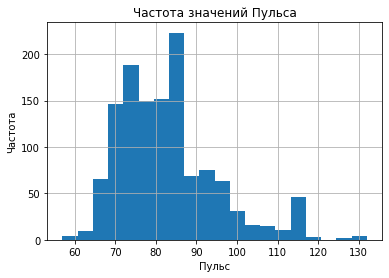

In [ ]:
df_spo2_.heartRate.hist(bins=20)
plt.xlabel('Пульс')
plt.ylabel('Частота')
plt.title('Частота значений Пульса')
plt.show()

Text(0.5, 1.0, 'Распределение значений heartRate в зависимости от sleep')

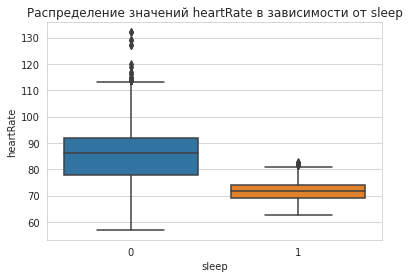

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=df_spo2_ , x = 'sleep', y = 'heartRate')
plt.title('Распределение значений heartRate в зависимости от sleep')

In [ ]:
df_spo2_['heartRate'].skew()

1.0244111832037124

In [ ]:
dates = df_spo2_.date.unique()

array(['2023-03-13T00:00:00.000000000', '2023-03-12T00:00:00.000000000',
       '2023-03-14T00:00:00.000000000', '2023-03-10T00:00:00.000000000',
       '2023-03-11T00:00:00.000000000'], dtype='datetime64[ns]')

Зависимость пульса от времени дня


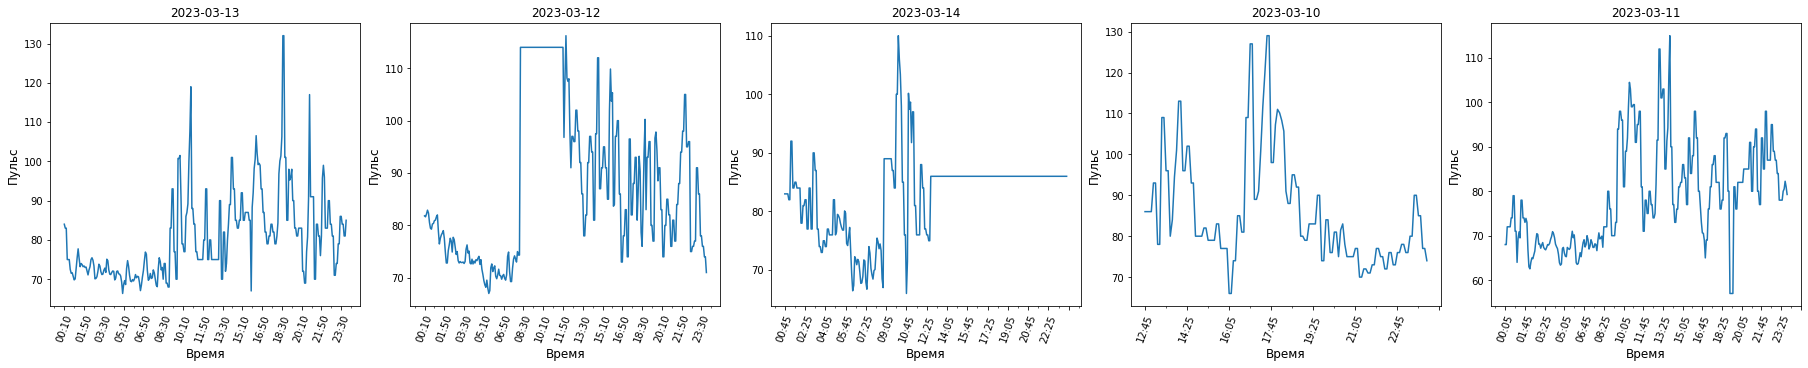

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(25, 5), layout="constrained")
ax = 0
plt.xticks(rotation=70)
fontsize=12
print('Зависимость пульса от времени дня')

for dat in dates:
  temp = df_spo2_[df_spo2_.date == dat][['heartRate','time']]

  temp.time = temp.time.astype(str)
  temp.time = temp.time.apply(lambda x: x[:5])

  axes[ax].plot(temp.time, temp.heartRate)

  axes[ax].xaxis.set_major_locator(ticker.MultipleLocator(20))
  axes[ax].xaxis.set_minor_locator(ticker.MultipleLocator(10))

  axes[ax].set_xlabel('Время', fontsize=fontsize)
  axes[ax].set_ylabel('Пульс', fontsize=fontsize)
  axes[ax].set_title(dat.astype(str)[:10], fontsize=fontsize)

  axes[ax].tick_params(axis='x', labelrotation=70)

  ax+=1

plt.show()

Похоже, что пульс зависит от времени, из-за чего следует зависимость на сон

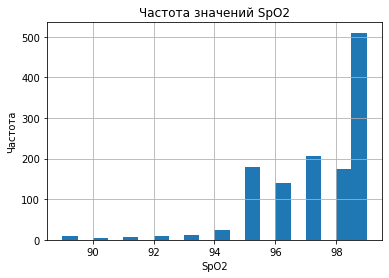

In [ ]:
df_spo2_.spo.hist(bins=20)
plt.xlabel('SpO2')
plt.ylabel('Частота')
plt.title('Частота значений SpO2')
plt.show()

Text(0.5, 1.0, 'Распределение значений SpO2 в зависимости от sleep')

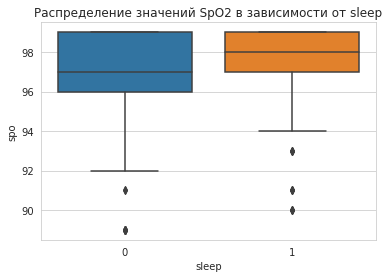

In [ ]:
sns.set_style("whitegrid")
sns.boxplot(data=df_spo2_ , x = 'sleep', y = 'spo')
plt.title('Распределение значений SpO2 в зависимости от sleep')

Зависимость значение SpO2 от времени дня


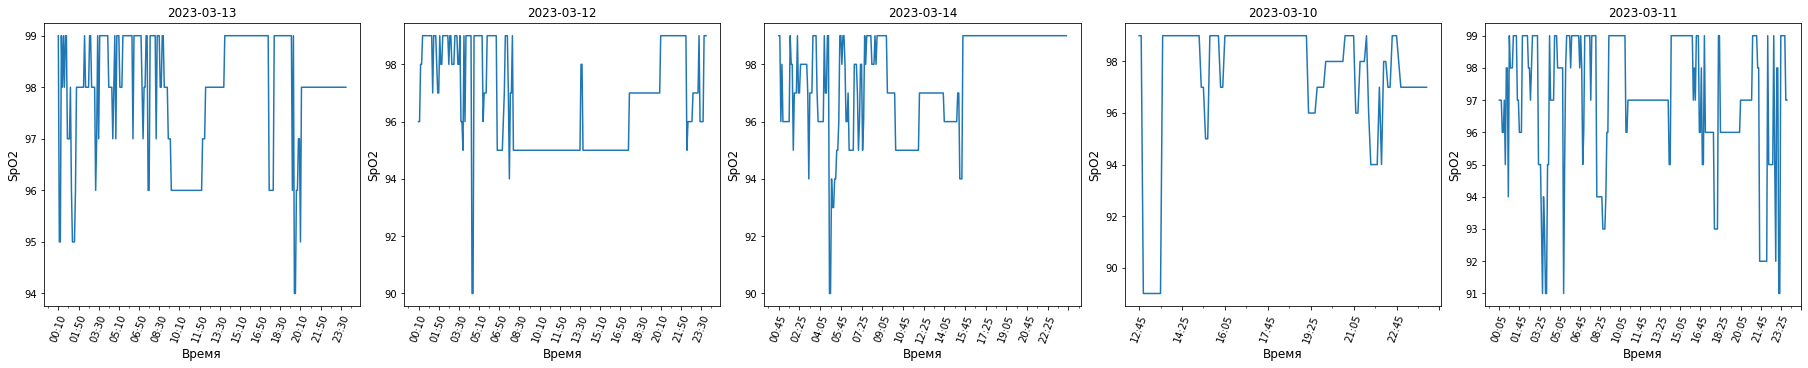

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(25, 5), layout="constrained")
ax = 0
plt.xticks(rotation=70)
fontsize=12
print('Зависимость значение SpO2 от времени дня')

for dat in dates:
  temp = df_spo2_[df_spo2_.date == dat][['spo','time']]

  temp.time = temp.time.astype(str)
  temp.time = temp.time.apply(lambda x: x[:5])

  axes[ax].plot(temp.time, temp.spo)

  axes[ax].xaxis.set_major_locator(ticker.MultipleLocator(20))
  axes[ax].xaxis.set_minor_locator(ticker.MultipleLocator(10))

  axes[ax].set_xlabel('Время', fontsize=fontsize)
  axes[ax].set_ylabel('SpO2', fontsize=fontsize)
  axes[ax].set_title(dat.astype(str)[:10], fontsize=fontsize)

  axes[ax].tick_params(axis='x', labelrotation=70)

  ax+=1

plt.show()

Зависимость SpO2 с временем, на первый взгляд, неясна

### Добавим признаки, исходя из имеющихся

In [ ]:
df_spo2_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 0 to 1272
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   spo        1273 non-null   int64              
 1   time       1273 non-null   object             
 2   date       1273 non-null   datetime64[ns]     
 3   date_time  1273 non-null   datetime64[ns, UTC]
 4   heartRate  1273 non-null   float64            
 5   sleep      1273 non-null   int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 101.9+ KB


In [ ]:
df_spo2_['year'] = df_spo2_.date.dt.year
df_spo2_['month'] = df_spo2_.date.dt.month
df_spo2_['day'] = df_spo2_.date.dt.day
df_spo2_['hour'] = df_spo2_.date_time.dt.hour
df_spo2_['minute'] = df_spo2_.date_time.dt.minute

df_spo2_['dayofweek'] = df_spo2_.date_time.dt.dayofweek
df_spo2_['seasons'] = df_spo2_.month.apply(lambda x: 'winter' if x in [12,1,2] else ('spring' if x in [3,4,5] else ('summer' if x in [6,7,8] else 'autumn'))) 

df_spo2_['time_of_day'] = df_spo2_.hour.apply(lambda x: 'night' if x in [0,1,2,3,4,5] else ('morning' if x in [6,7,8,9,10,11,12] else ('evening' if x in [18,19,20,21,22,23] else 'day'))) 
df_spo2_

,spo,time,date,date_time,heartRate,sleep,year,month,day,hour,minute,dayofweek,seasons,time_of_day
0,99,00:10:00,2023-03-13,2023-03-13 00:10:00+00:00,84.000000,0,2023,3,13,0,10,0,spring,night
1,95,00:15:00,2023-03-13,2023-03-13 00:15:00+00:00,83.000000,0,2023,3,13,0,15,0,spring,night
2,95,00:20:00,2023-03-13,2023-03-13 00:20:00+00:00,83.000000,0,2023,3,13,0,20,0,spring,night
3,99,00:25:00,2023-03-13,2023-03-13 00:25:00+00:00,75.000000,1,2023,3,13,0,25,0,spring,night
4,98,00:30:00,2023-03-13,2023-03-13 00:30:00+00:00,75.000000,1,2023,3,13,0,30,0,spring,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,99,23:35:00,2023-03-11,2023-03-11 23:35:00+00:00,80.000000,1,2023,3,11,23,35,5,spring,evening
1269,99,23:40:00,2023-03-11,2023-03-11 23:40:00+00:00,80.500000,1,2023,3,11,23,40,5,spring,evening
1270,99,23:45:00,2023-03-11,2023-03-11 23:45:00+00:00,82.250000,1,2023,3,11,23,45,5,spring,evening
1271,97,23:50:00,2023-03-11,2023-03-11 23:50:00+00:00,81.000000,1,2023,3,11,23,50,5,spring,evening


Корреляция и распределение новых признаков

In [ ]:
new_cols = ['year',	'month',	'day',	'hour',	'minute',	'dayofweek',	'seasons', 'time_of_day']
len(new_cols)

8

In [ ]:
for col in new_cols:
  print('For col',col,' unique vales: ', df_spo2_[col].unique())

For col year  unique vales:  [2023]
For col month  unique vales:  [3]
For col day  unique vales:  [13 12 14 10 11]
For col hour  unique vales:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
For col minute  unique vales:  [10 15 20 25 30 35 40 45 50 55  0  5]
For col dayofweek  unique vales:  [0 6 1 4 5]
For col seasons  unique vales:  ['spring']
For col time_of_day  unique vales:  ['night' 'morning' 'day' 'evening']


Распределение новых признаков на гистограмме


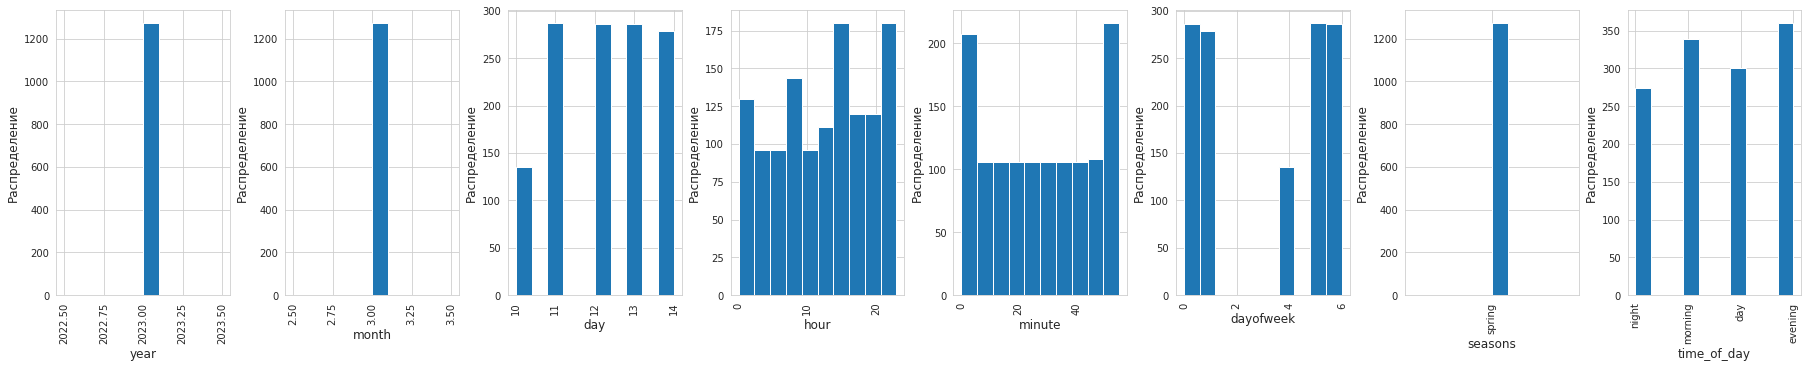

In [ ]:
fig, axes = plt.subplots(ncols=len(new_cols), figsize=(25, 5), layout="constrained")
ax = 0
plt.xticks(rotation=70)
fontsize=12

print('Распределение новых признаков на гистограмме')

for col in new_cols:

  axes[ax].hist(df_spo2_[col])

  axes[ax].set_xlabel(col, fontsize=fontsize)
  axes[ax].set_ylabel('Распределение', fontsize=fontsize)

  axes[ax].tick_params(axis='x', labelrotation=90)

  ax+=1

plt.show()

Видно, что пока такие признаки как год, месяц и сезон не будут объективно полезными из-за малого набора в данных, однако их можно считать потенциально полезными при увеличении объема данных. Эта же ситуация характерна и для дня.

Удалим признаки для дальнейшего обучения

In [ ]:
df_spo2_.drop(['year','month','seasons'],axis=1,inplace=True)

### Посмотрим на распределение целевой переменной

In [ ]:
dates.sort()

Зависимость значение целевой переменной от времени дня


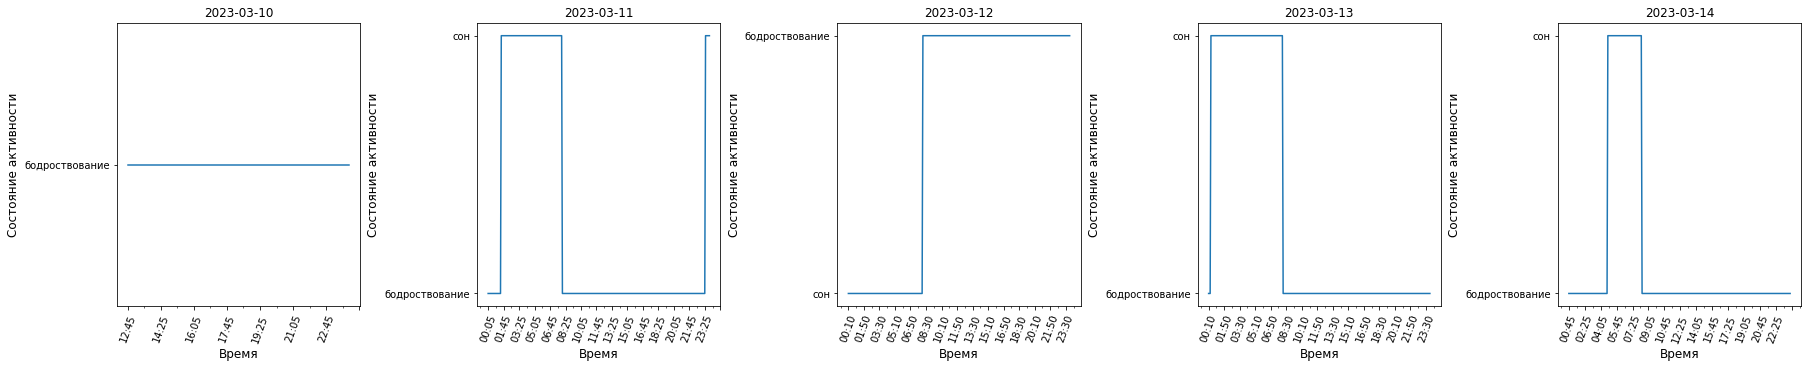

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(25, 5), layout="constrained")
ax = 0
plt.xticks(rotation=70)
fontsize=12

print('Зависимость значение целевой переменной от времени дня')

for dat in dates:
  temp = df_spo2_[df_spo2_.date == dat][['sleep','time']]

  temp.time = temp.time.astype(str)
  temp.time = temp.time.apply(lambda x: x[:5])
  temp.sleep = temp.sleep.apply(lambda x: 'сон' if x==1 else 'бодроствование')

  axes[ax].plot(temp.time, temp.sleep)

  axes[ax].xaxis.set_major_locator(ticker.MultipleLocator(20))
  axes[ax].xaxis.set_minor_locator(ticker.MultipleLocator(10))

  axes[ax].set_xlabel('Время', fontsize=fontsize)
  axes[ax].set_ylabel('Состояние активности', fontsize=fontsize)
  axes[ax].set_title(dat.astype(str)[:10], fontsize=fontsize)

  axes[ax].tick_params(axis='x', labelrotation=70)

  ax+=1

plt.show()

Получилось, что сна совершенно нет в данных от 10.03 и совсем маленький промежуток 14.03

In [ ]:
df_spo2_.sleep.value_counts()

0    956
1    317
Name: sleep, dtype: int64

Заметно, что в задаче присутствует дисбаланс классов => **будем использовать метрику ROC-AUC, тогда дисбаланс классов нет необходимости выравнивать, потому что метрика не чувствительна к смещению.**

# Разделение данных на обучающую и тестовую выборку 

In [ ]:
df_spo2_.head()

,spo,time,date,date_time,heartRate,sleep,day,hour,minute,dayofweek,time_of_day
0,99,00:10:00,2023-03-13,2023-03-13 00:10:00+00:00,84.0,0,13,0,10,0,night
1,95,00:15:00,2023-03-13,2023-03-13 00:15:00+00:00,83.0,0,13,0,15,0,night
2,95,00:20:00,2023-03-13,2023-03-13 00:20:00+00:00,83.0,0,13,0,20,0,night
3,99,00:25:00,2023-03-13,2023-03-13 00:25:00+00:00,75.0,1,13,0,25,0,night
4,98,00:30:00,2023-03-13,2023-03-13 00:30:00+00:00,75.0,1,13,0,30,0,night


In [ ]:
X = df_spo2_.drop(['time','date','date_time','sleep'],axis=1)
y = df_spo2_.sleep  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42 )

In [ ]:
X_train.sample(5)

,spo,heartRate,day,hour,minute,dayofweek,time_of_day
520,97,97.833333,12,19,40,6,evening
571,99,71.000000,12,23,55,6,evening
1261,92,87.000000,11,23,0,5,evening
320,98,73.272727,12,3,0,6,night
1225,96,82.000000,11,20,0,5,evening


In [ ]:
categoric = ['hour', 'day', 'minute','dayofweek','time_of_day' ]
numeric = ['heartRate','spo']

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe',OneHotEncoder(handle_unknown="ignore"),categoric),
    ('scaling',StandardScaler(),numeric),
])

X_train = column_transformer.fit_transform(X_train)  
X_test = column_transformer.fit_transform(X_test)  

# Обучение моделей

Задача бинарной классификации, попробуем ряд моделей для выявления лучшей

In [ ]:
def get_answer(clf, X_train, y_train, X_test):
    '''Функция получения предсказаний классификатора clf'''
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Z = clf.predict_proba(X_test)[:, 1]
    
    return y_pred, Z

In [ ]:
def get_metrics(y_test, y_pred, Z, name, prec=5):
    '''Получаем метрики и визуализируем результат'''
    print(name)
    # матрица ошибок
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
       
    class_names = [0,1] # имена классов
    fig, ax1 = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # создаем heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="GnBu" ,fmt='g')
    ax1.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
     
    # найдем precision и recall
    pr = metrics.precision_score(y_test, y_pred) 
    print(f'precision={round(pr, prec)}')
    rc = metrics.recall_score(y_test, y_pred) 
    print(f'recall={round(rc, prec)}')

    # AUC ROC
    fpr, tpr, _ = metrics.roc_curve(y_test,  Z)
    roc_auc = metrics.roc_auc_score(y_test, Z)
    print(f'roc-auc={round(roc_auc, prec)}')

    fig, ax2 = plt.subplots()
    plt.plot(fpr,tpr,label=f"auc={round(roc_auc, prec)}")
    plt.title(f'ROC-AUC for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--', label='Random clf')
    plt.legend(loc=4)
    plt.show()
    
    #AUC_PR
    precision, recall, _ = metrics.precision_recall_curve(y_test,  Z)
    pr_auc = metrics.auc(recall, precision)
    print(f'pr_auc={pr_auc}')

    fig, ax3 = plt.subplots()
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot(recall, precision)
    plt.title(f'PR-AUC for {name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0],  [no_skill, 1], 'k--', label='Random clf')
    plt.legend(loc=1)
    plt.show()

## GradientBoostingClassifier

In [ ]:
boosting = GradientBoostingClassifier()
y_pred, Z = get_answer(boosting, X_train, y_train, X_test)

RandomForestClassifier
precision=0.94118
recall=0.9505
roc-auc=0.99757


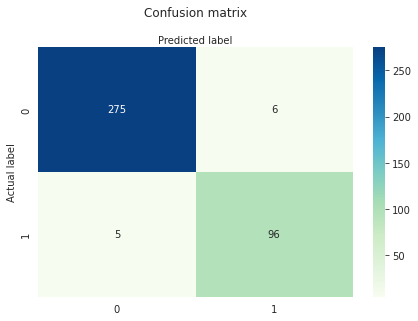

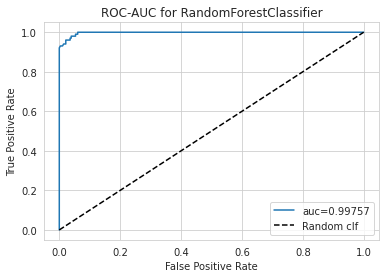

pr_auc=0.9937845927849306


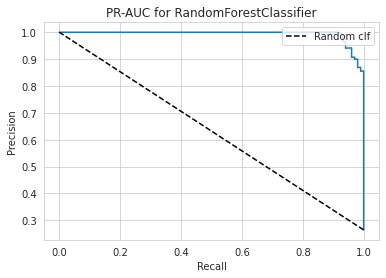

In [ ]:
get_metrics(y_test, y_pred, Z, 'RandomForestClassifier') 

## RandomForestClassifier

In [ ]:
forest = RandomForestClassifier()
y_pred, Z = get_answer(forest, X_train, y_train, X_test)

RandomForestClassifier
precision=0.9697
recall=0.9505
roc-auc=0.99734


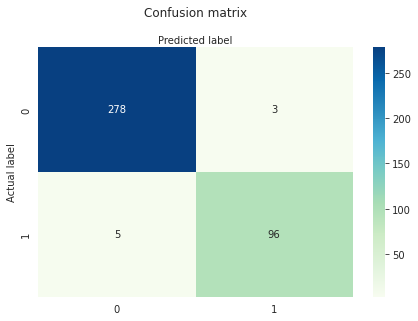

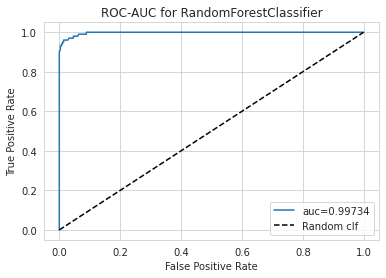

pr_auc=0.9934342703942904


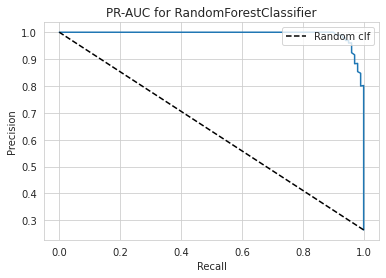

In [ ]:
get_metrics(y_test, y_pred, Z, 'RandomForestClassifier') 

### CatBoostClassifier

In [ ]:
cat = CatBoostClassifier(iterations=10,
                           depth=5,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           verbose=True)
y_pred, Z = get_answer(cat, X_train, y_train, X_test)

0:	learn: 0.5361183	total: 1.29ms	remaining: 11.6ms
1:	learn: 0.4267473	total: 5.89ms	remaining: 23.6ms
2:	learn: 0.3822194	total: 8.39ms	remaining: 19.6ms
3:	learn: 0.3118728	total: 9.76ms	remaining: 14.6ms
4:	learn: 0.2752945	total: 10.6ms	remaining: 10.6ms
5:	learn: 0.2379912	total: 11.6ms	remaining: 7.74ms
6:	learn: 0.2120462	total: 12.6ms	remaining: 5.4ms
7:	learn: 0.1906177	total: 13.4ms	remaining: 3.35ms
8:	learn: 0.1730589	total: 14.3ms	remaining: 1.58ms
9:	learn: 0.1610825	total: 15.2ms	remaining: 0us


CatBoostClassifier
precision=0.94898
recall=0.92079
roc-auc=0.98518


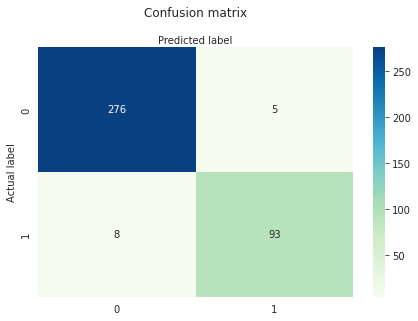

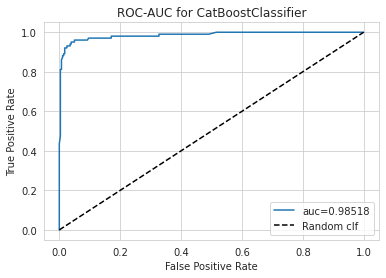

pr_auc=0.9708508037942389


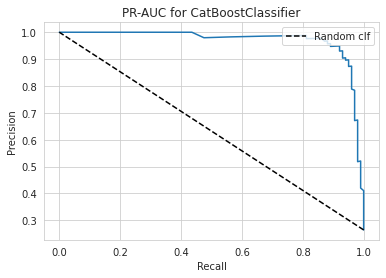

In [ ]:
get_metrics(y_test, y_pred, Z, 'CatBoostClassifier') 

# Удаление выбросов, подбор гиперпараметров, оценка влияния на результат

Сделать вывод по проделанной работе (выдать численные значения и сравнительную таблицу по аналогичным решениям по accuracy/f1 score, описать полученные значения и возможные ограничения полученного решения и будущего улучшения).

# Лучший метод

# Ограничения полученного решения

Из анализа данных получилось:

1. Признаки такие, как месяц, год, сезон не имеют большой вариативности и из-за этого их вклад в общий результат нулевой. Для дальнейшего же развития следует оставить эти признаки и обучать вместе с ними, так как логично предположить, что сезон года будет влиять на сон.

2. Возможно следовало оставить выбросы, так как неясно, будут ли они также являться выбросами при увеличении объема данных